In [ ]:
import sys
!{sys.executable} -m pip install gym

In [ ]:
from amalearn.environment import EnvironmentBase
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase

import gym
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

In [254]:
class Environment(EnvironmentBase):
    def __init__(self, obstacle =[] ,id = 0, action_count=9, actionPrice = -1, goalReward = 100, 
                 punish=-10, j_limit = 10, i_limit = 10, p = 0.8, container=None):
        """
        initialize your variables
        """
        if not obstacle:
            obstacle = [(7,1), (7,2), (7,3), (7,4), (8,1), (8,2), (8,3), (8,4), (6,12), (6,13), (6,14), (6,15), (7,12),
                        (7,13), (7,14), (7,15), (13,8), (13,9), (14,8), (14,9), (15,8), (15,9)]
        self.obstacle = obstacle
        self.action_count = action_count
        self.actionPrice = actionPrice
        self.goalReward = goalReward
        self.punish = punish
        self.j_limit = j_limit
        self.i_limit = i_limit
        self.p = p
        self.goal = (1,1)
        self.done = False
        
        action_space = self.available_actions()
        state_space = [(i, j) for i in range(1,16) for j in range(1,16)]
        super(Environment, self).__init__(action_space, state_space, id, container)
        
    def isStatePossible(self, state):
        """if given state is possible (not out of the grid and not obstacle) return ture"""
        if state[0]<1 or state[0]>self.i_limit or state[1]<1 or state[1]>self.j_limit:
            return False
        if state in self.obstacle:
            return False
        return True
    
    def isAccessible(self, state, state_p):
        """if given state is Accesible (we can reach state_p by doing an action from state) return true"""
        if state_p[0] - state[0] in [-1, 0, 1] and  state_p[1] - state[1] in [-1, 0, 1]:
            return True
        else:
            return False
    
    def getTransitionStatesAndProbs(self, state, action, state_p):
        """return probability of transition or T(sp,a,s)"""
        self.state = state
        next_state = self.next_state(action)
        if state_p == next_state:
            return self.p
        else:
            if state_p in [(state[0]+i, state[1]+j) for i in [-1, 0, 1] for j in [-1, 0, 1]]:
                return (1-self.p)/8
            else:
                return 0 
        
    def getReward(self, state, action, state_p):
        """return reward of transition"""
        reward = 0
        if action != 'stay':
            reward = self.actionPrice
        if not self.isStatePossible(state_p):
            reward += self.punish
            state_p = state
        if state_p == self.goal:
            reward += self.goalReward
        return reward
    
    def sample_all_rewards(self):
        return 
    
    def calculate_reward(self, action):
        """ Get reward of action """
        state_p = self.next_state(action)
        reward = self.getReward(self.state, action, state_p)
        return reward

    def terminated(self):
        return self.done

    def observe(self):
        if self.state == self.goal:
            return 'goal'
        elif self.state in self.obstacle:
            return 'obstacle'
        else:
            return 'normal'

    def available_actions(self):
        return ['stay', 'up', 'up-right', 'right', 'down-right', 'down', 'down-left', 'left', 'up-left']

    def next_state(self, action):
        if action == 'stay':
            state_p = (self.state[0], self.state[1])
        elif action == 'up':
            state_p = (self.state[0], self.state[1]-1)
        elif action == 'up-right': 
            state_p = (self.state[0]+1, self.state[1]-1)
        elif action == 'right': 
            state_p = (self.state[0]+1, self.state[1])
        elif action == 'down-right': 
            state_p = (self.state[0]+1, self.state[1]+1)
        elif action == 'down': 
            state_p = (self.state[0], self.state[1]+1)
        elif action == 'down-left': 
            state_p = (self.state[0]-1, self.state[1]+1)
        elif action == 'left': 
            state_p = (self.state[0]-1, self.state[1])
        elif action == 'up-left': 
            state_p = (self.state[0]-1, self.state[1]-1)
            
        return state_p

    def reset(self):
        self.state = (15, 15)

    def render(self, mode='human'):
        print('state: {}'.format(self.state[0], self.state[1]))
        return 

    def close(self):
        return

In [255]:
class Agent(AgentBase):
    def __init__(self, environment, discount, theta, id=0):
        #initialize a random policy and V(s) = 0 for each state
        self.environment = environment
        mapp = {}
        k = 0
        for i in range(1, environment.i_limit+1):
            for j in range(1, environment.j_limit+1):
                mapp[(i, j)] = k 
                k += 1
        self.mapp = mapp  #mapp states to its ids
        self.V = {i:0 for i in self.mapp.values()}  ## initialize values of states to 0
        self.policy = {i: random.choice(self.environment.available_actions())
                        for i in self.mapp.values()}
        super(Agent, self).__init__(id, environment)
        self.discount = discount
        self.theta = theta
        self.delta = 0
        
    def policy_evaluation(self):
        """ This function is part of policy iteration algorithm """
        self.delta = math.inf
        while self.delta >= self.theta:
            self.delta = 0
            V_temp = copy.deepcopy(self.V)
            for state, state_id in self.mapp.items():  ## iterate all states
                self.environment.state = state
                state_id = self.mapp[state]
                v_temp = self.V[state_id]
                new_v = 0
                for action in self.environment.available_actions():
                    next_state = self.environment.next_state(action)

                    first_param = self.environment.getTransitionStatesAndProbs(state, self.policy[state_id], next_state)
                    second_param = self.environment.calculate_reward(action)
                    if not self.environment.isStatePossible(next_state):
                        next_state = state        
                    third_param = self.discount*self.V[self.mapp[next_state]]
                    new_v += first_param * (second_param + third_param)
                self.delta = max(self.delta, abs(v_temp-new_v))
                V_temp[state_id] = new_v
            self.V = copy.deepcopy(V_temp)
        
                
    def policy_improvement(self):
        """ This function is part of policy iteration algorithm """
        for state, state_id in self.mapp.items():
            self.environment.state = state
            info = self.take_action()
            stable = info[2]
        return stable
                
    def value_iteration(self):
        """ Function to run value iteratoin """
        self.V[self.mapp[self.environment.goal]] = 0
        self.delta = math.inf
        while self.delta >= self.theta:
            self.delta = 0
            V_temp = copy.deepcopy(self.V)
            for state, state_id in self.mapp.items():  ## iterate all states
                self.environment.state = state
                state_id = self.mapp[state]
                v_temp = self.V[state_id]
                best_v = -math.inf  ## best value based on best action
                for action in self.environment.available_actions():
                    new_v = 0
                    for action_for_state in self.environment.available_actions():
                        next_state = self.environment.next_state(action_for_state)               
                        first_param = self.environment.getTransitionStatesAndProbs(state, action, next_state)
                        second_param = self.environment.calculate_reward(action_for_state)
                        if not self.environment.isStatePossible(next_state):
                            next_state = state  
                        third_param = self.discount*self.V[self.mapp[next_state]]
                        new_v += first_param * (second_param + third_param)
                    if best_v < new_v:
                        best_v = new_v  
                V_temp[state_id] = best_v
                self.delta = max(self.delta, abs(v_temp-best_v))
            self.V = copy.deepcopy(V_temp)
        for state, state_id in self.mapp.items():
            self.environment.state = state
            info = self.take_action()
                    
    
    def take_action(self) -> (object, float, bool, object):
        state = self.environment.state
        state_id = self.mapp[state]
        temp_pi = self.policy[state_id]
        best_action = None
        best_v = -math.inf
        stable = True
        for action in self.environment.available_actions():
            new_v = 0
            for action_for_state in self.environment.available_actions():
                next_state = self.environment.next_state(action_for_state)               
                first_param = self.environment.getTransitionStatesAndProbs(state, action, next_state)
                second_param = self.environment.calculate_reward(action_for_state)
                if not self.environment.isStatePossible(next_state):
                    next_state = state  
                third_param = self.discount*self.V[self.mapp[next_state]]
                new_v += first_param * (second_param + third_param)
            if best_v < new_v:
                best_v = new_v
                best_action = action
        self.policy[state_id] = best_action
        if temp_pi != best_action:
            stable = False
        self.environment.done = stable
        return self.environment.step(best_action)
    
    def run_policy_based(self):
        """ Function to run policy iteration """
        stable = True
        while True:
            self.policy_evaluation()
            stable = self.policy_improvement()
            if stable:
                break
    
    def run_value_based(self):
        """ Function to run value iteration """
        self.value_iteration()

In [256]:
def plot_res(agent, environment, title):
    """ This function plot a table to show result of algorithm graphically """
    plot_data = [[None for _ in range(15)] for _ in range(15)]
    act2sign = {'stay': 'O', 'up': '\u2191', 'up-right': '\u2197', 'right': '\u2192', 'down-right': '\u2198', 'down': '\u2193', 
                'down-left': '\u2199', 'left': '\u2190', 'up-left': '\u2196'}
    for i in range(15):
        for j in range(15):
            state = (i+1, j+1)
            act = agent.policy[agent.mapp[state]]
            if state in environment.obstacle:
                plot_data[j][i] = '\u2589\u2589'  ## obstacles
            else:
                plot_data[j][i] = act2sign[act]
    
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.table(cellText=plot_data, colLabels=range(1, 16), rowLabels=range(1, 16), loc='center')
    fig.tight_layout()
    plt.title(title)
    plt.show()

#### A) Base parameters, discount_factor=0.9

In [259]:
environment = Environment(actionPrice = -0.01, goalReward = 1000, punish=-1, j_limit = 15, i_limit = 15, p = 0.8)
agent = Agent(environment=environment, discount=0.9, theta=0.0001)
agent.run_policy_based()

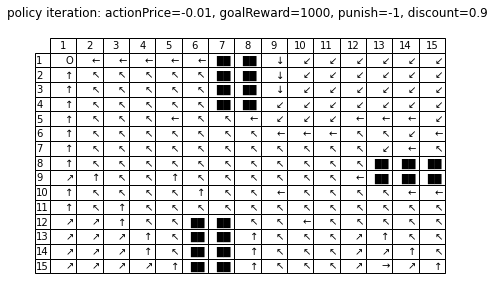

In [260]:
title = 'policy iteration: actionPrice={0}, goalReward={1}, punish={2}, discount={3}'.format(-0.01, 1000, -1, 0.9)
plot_res(agent, environment, title)

#### B) Without action price

In [243]:
environment = Environment(actionPrice = 0, goalReward = 1000, punish=-0.01, j_limit = 15, i_limit = 15, p = 0.8)
agent = Agent(environment=environment, discount=0.9, theta=0.01)
agent.run_policy_based()

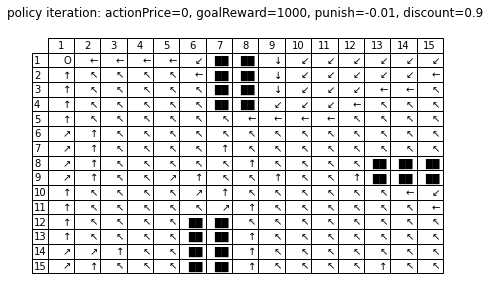

In [244]:
title = 'policy iteration: actionPrice={0}, goalReward={1}, punish={2}, discount={3}'.format(0, 1000, -0.01, 0.9)
plot_res(agent, environment, title)

#### C) With high action price

In [245]:
environment = Environment(actionPrice = -1, goalReward = 100, punish=-10, j_limit = 15, i_limit = 15, p = 0.8)
agent = Agent(environment=environment, discount=0.9, theta=0.001)
agent.run_policy_based()

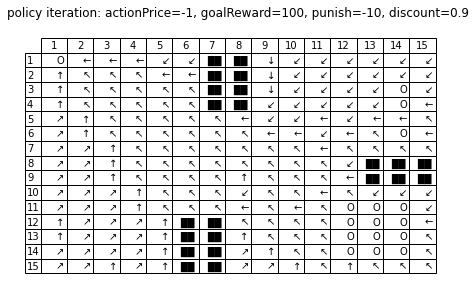

In [248]:
title = 'policy iteration: actionPrice={0}, goalReward={1}, punish={2}, discount={3}'.format(-1, 100, -10, 0.9)
plot_res(agent, environment, title)

#### D) Find best discount factor

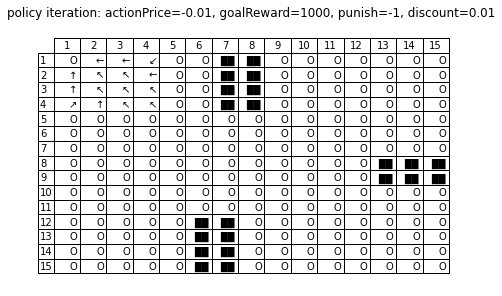

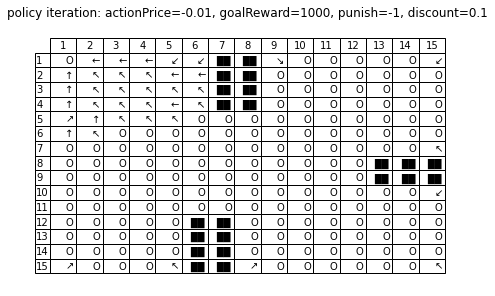

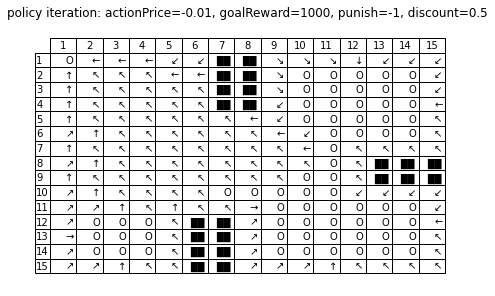

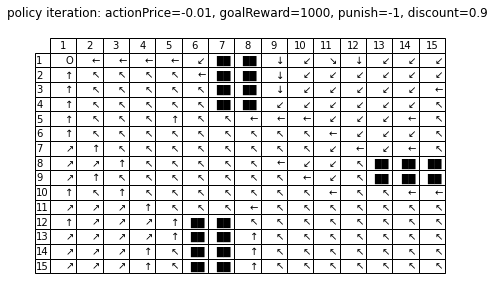

In [251]:
for discount in [0.01, 0.1, 0.5, 0.9]:
    environment = Environment(actionPrice = -0.01, goalReward = 1000, punish=-1, j_limit = 15, i_limit = 15, p = 0.8)
    agent = Agent(environment=environment, discount=discount, theta=0.0001)
    agent.run_policy_based()
    title = 'policy iteration: actionPrice={0}, goalReward={1}, punish={2}, discount={3}'.format(-0.01, 1000, -1, discount)
    plot_res(agent, environment, title)

#### E) Run value iteration to find best policies

In [252]:
environment = Environment(actionPrice = -0.01, goalReward = 1000, punish=-1, j_limit = 15, i_limit = 15, p = 0.8)
agent = Agent(environment=environment, discount=0.9, theta=0.0001)
agent.run_value_based()

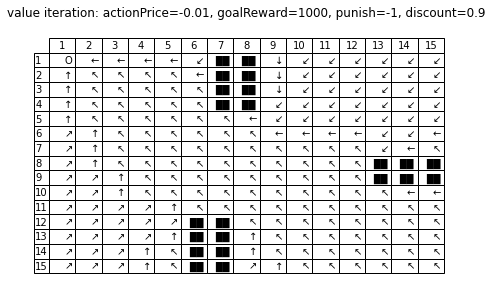

In [253]:
title = 'value iteration: actionPrice={0}, goalReward={1}, punish={2}, discount={3}'.format(-0.01, 1000, -1, 0.9)
plot_res(agent, environment, title)